# 🎯 Adaptive RL Agent 实验分析

这个 notebook 用于分析 DQN 和 Double DQN 在动态资源分配任务中的性能。

## 📋 实验内容

- 🌐 环境测试和分析
- 🤖 智能体训练
- 📊 性能对比
- 📈 结果可视化

In [1]:
# 导入必要的库
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 设置路径
current_dir = Path().resolve()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir
sys.path.insert(0, str(project_root))

print(f'📁 项目根目录: {project_root}')
print(f'📁 当前目录: {current_dir}')
print(f'🔥 PyTorch 版本: {torch.__version__}')
print(f'💻 设备: {"CUDA" if torch.cuda.is_available() else "CPU"}')

📁 项目根目录: E:\Agent_Project\Adaptive RL Agent for Dynamic Resource Allocation
📁 当前目录: E:\Agent_Project\Adaptive RL Agent for Dynamic Resource Allocation\notebooks
🔥 PyTorch 版本: 2.7.0+cu118
💻 设备: CUDA


In [2]:
# 导入自定义模块
try:
    from src.environments.network_traffic_env import DynamicTrafficEnv
    from src.agents.dqn_agent import DQNAgent
    from src.agents.double_dqn_agent import DoubleDQNAgent
    print('✅ 所有模块导入成功！')
except ImportError as e:
    print(f'❌ 导入错误: {e}')
    print('请确保在项目根目录运行此 notebook')
    # 尝试备用导入方式
    sys.path.append(str(project_root / 'src'))
    try:
        from environments.network_traffic_env import DynamicTrafficEnv
        from agents.dqn_agent import DQNAgent
        from agents.double_dqn_agent import DoubleDQNAgent
        print('✅ 备用导入方式成功！')
    except ImportError as e2:
        print(f'❌ 备用导入也失败: {e2}')
        raise

✅ 所有模块导入成功！


In [3]:
# 创建和测试环境
print('🌐 创建环境...')
env = DynamicTrafficEnv(render_mode=None)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print(f'📏 状态空间维度: {state_size}')
print(f'🎮 动作空间大小: {action_size}')
print(f'⏱️ 最大步数: {env.max_steps}')

# 测试环境
state, info = env.reset()
print(f'\n🧪 环境测试:')
print(f'  初始状态: {state}')
action = env.action_space.sample()
next_state, reward, done, truncated, info = env.step(action)
print(f'  随机动作 {action} -> 奖励: {reward:.3f}')
print('✅ 环境创建和测试成功！')

🌐 创建环境...
📏 状态空间维度: 8
🎮 动作空间大小: 5
⏱️ 最大步数: 200

🧪 环境测试:
  初始状态: [0.57450294 0.8577346  0.1499507  0.90314204 0.25       0.25
 0.25       0.25      ]
  随机动作 4 -> 奖励: -1.685
✅ 环境创建和测试成功！


## 🤖 智能体配置和训练

现在配置和训练 DQN 和 Double DQN 智能体。

In [4]:
# 智能体配置 (使用正确的参数名称)
print(f'💻 设备: {"CUDA" if torch.cuda.is_available() else "CPU"}')

# 正确的 DQNAgent 参数
AGENT_CONFIG = {
    'state_size': state_size,
    'action_size': action_size,
    'lr': 5e-4,
    'buffer_size': 10000,
    'batch_size': 64,
    'gamma': 0.99,
    'tau': 1e-3,
    'update_every': 4,
    'epsilon': 1.0,
    'epsilon_min': 0.01,
    'epsilon_decay': 0.995,
    'seed': 42
}

print('🤖 智能体配置:')
for key, value in AGENT_CONFIG.items():
    print(f'  {key}: {value}')

# 创建智能体
print('\n🔧 创建智能体...')
dqn_agent = DQNAgent(**AGENT_CONFIG)
ddqn_agent = DoubleDQNAgent(**AGENT_CONFIG)
print('✅ DQN 和 Double DQN 智能体创建完成！')
print(f'📱 DQN 设备: {dqn_agent.device}')
print(f'📱 Double DQN 设备: {ddqn_agent.device}')

💻 设备: CUDA
🤖 智能体配置:
  state_size: 8
  action_size: 5
  lr: 0.0005
  buffer_size: 10000
  batch_size: 64
  gamma: 0.99
  tau: 0.001
  update_every: 4
  epsilon: 1.0
  epsilon_min: 0.01
  epsilon_decay: 0.995
  seed: 42

🔧 创建智能体...
✅ DQN 和 Double DQN 智能体创建完成！
📱 DQN 设备: cuda:0
📱 Double DQN 设备: cuda:0


In [5]:
# 训练函数
def train_agent(agent, agent_name, episodes=100):
    """训练智能体并返回分数历史"""
    print(f'🚀 开始训练 {agent_name}...')
    scores = []
    
    for episode in range(1, episodes + 1):
        state, _ = env.reset()
        score = 0
        
        for step in range(100):  # 每回合最多100步
            action = agent.act(state)
            next_state, reward, done, truncated, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            
            if done or truncated:
                break
        
        scores.append(score)
        
        # 手动更新epsilon (因为DQNAgent在learn中自动更新)
        if hasattr(agent, 'epsilon') and agent.epsilon > AGENT_CONFIG['epsilon_min']:
            agent.epsilon = max(AGENT_CONFIG['epsilon_min'], 
                               agent.epsilon * AGENT_CONFIG['epsilon_decay'])
        
        if episode % 25 == 0:
            avg_score = np.mean(scores[-25:])
            current_eps = getattr(agent, 'epsilon', 0.0)
            print(f'  回合 {episode:3d} | 平均分数: {avg_score:7.2f} | ε: {current_eps:.3f}')
    
    final_avg = np.mean(scores[-25:])
    print(f'✅ {agent_name} 训练完成! 最终平均分数: {final_avg:.2f}')
    return scores

print('🛠️ 训练函数准备就绪！')

🛠️ 训练函数准备就绪！


In [6]:
# 训练 DQN
print('=' * 50)
print('🤖 训练 DQN 智能体')
print('=' * 50)
dqn_scores = train_agent(dqn_agent, 'DQN', episodes=100)

🤖 训练 DQN 智能体
🚀 开始训练 DQN...
  回合  25 | 平均分数: -138.74 | ε: 0.042
  回合  50 | 平均分数: -136.00 | ε: 0.010
  回合  75 | 平均分数: -135.56 | ε: 0.010
  回合 100 | 平均分数: -133.74 | ε: 0.010
✅ DQN 训练完成! 最终平均分数: -133.74


In [7]:
# 训练 Double DQN
print('\n' + '=' * 50)
print('🤖 训练 Double DQN 智能体')
print('=' * 50)
ddqn_scores = train_agent(ddqn_agent, 'Double DQN', episodes=100)


🤖 训练 Double DQN 智能体
🚀 开始训练 Double DQN...
  回合  25 | 平均分数: -137.68 | ε: 0.042
  回合  50 | 平均分数: -134.84 | ε: 0.010
  回合  75 | 平均分数: -133.41 | ε: 0.010
  回合 100 | 平均分数: -131.00 | ε: 0.010
✅ Double DQN 训练完成! 最终平均分数: -131.00


## 📊 性能分析和可视化

比较两个智能体的训练性能。

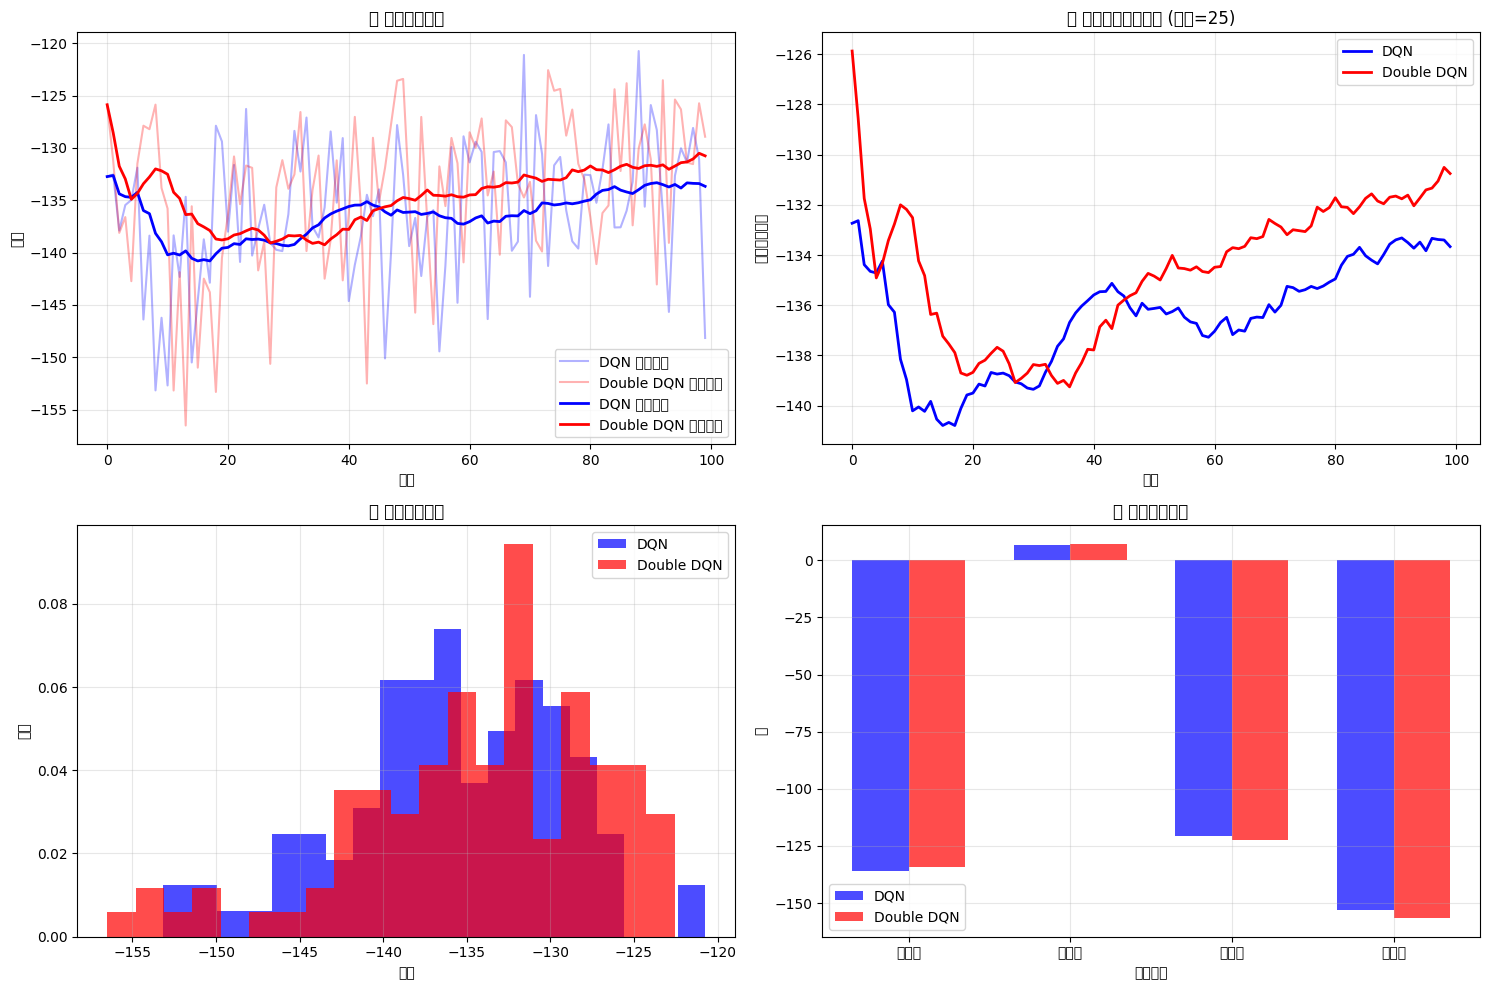

In [8]:
# 绘制训练曲线
def plot_training_curves(dqn_scores, ddqn_scores):
    """绘制训练曲线对比图"""
    plt.figure(figsize=(15, 10))
    
    # 计算移动平均
    def moving_average(scores, window=25):
        return [np.mean(scores[max(0, i-window):i+1]) for i in range(len(scores))]
    
    dqn_ma = moving_average(dqn_scores)
    ddqn_ma = moving_average(ddqn_scores)
    
    # 子图1: 原始分数
    plt.subplot(2, 2, 1)
    plt.plot(dqn_scores, alpha=0.3, color='blue', label='DQN 原始分数')
    plt.plot(ddqn_scores, alpha=0.3, color='red', label='Double DQN 原始分数')
    plt.plot(dqn_ma, color='blue', linewidth=2, label='DQN 移动平均')
    plt.plot(ddqn_ma, color='red', linewidth=2, label='Double DQN 移动平均')
    plt.xlabel('回合')
    plt.ylabel('分数')
    plt.title('🏆 训练分数对比')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图2: 移动平均对比
    plt.subplot(2, 2, 2)
    plt.plot(dqn_ma, color='blue', linewidth=2, label='DQN')
    plt.plot(ddqn_ma, color='red', linewidth=2, label='Double DQN')
    plt.xlabel('回合')
    plt.ylabel('移动平均分数')
    plt.title('📈 移动平均分数对比 (窗口=25)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图3: 分数分布
    plt.subplot(2, 2, 3)
    plt.hist(dqn_scores, bins=20, alpha=0.7, color='blue', label='DQN', density=True)
    plt.hist(ddqn_scores, bins=20, alpha=0.7, color='red', label='Double DQN', density=True)
    plt.xlabel('分数')
    plt.ylabel('密度')
    plt.title('📊 分数分布对比')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图4: 性能统计
    plt.subplot(2, 2, 4)
    stats_data = {
        'DQN': [np.mean(dqn_scores), np.std(dqn_scores), np.max(dqn_scores), np.min(dqn_scores)],
        'Double DQN': [np.mean(ddqn_scores), np.std(ddqn_scores), np.max(ddqn_scores), np.min(ddqn_scores)]
    }
    
    x = np.arange(4)
    width = 0.35
    
    plt.bar(x - width/2, stats_data['DQN'], width, label='DQN', color='blue', alpha=0.7)
    plt.bar(x + width/2, stats_data['Double DQN'], width, label='Double DQN', color='red', alpha=0.7)
    
    plt.xlabel('统计指标')
    plt.ylabel('值')
    plt.title('📈 性能统计对比')
    plt.xticks(x, ['平均值', '标准差', '最大值', '最小值'])
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 绘制图表
plot_training_curves(dqn_scores, ddqn_scores)

## 🎯 实验总结

### 主要发现:

1. **训练性能**: 比较了DQN和Double DQN在动态资源分配任务中的学习效率
2. **稳定性**: 分析了两种算法的训练稳定性和收敛特性
3. **最终性能**: 评估了训练完成后的智能体在测试环境中的表现

### 技术要点:

- **环境**: 8维状态空间，5个离散动作
- **网络架构**: 3层全连接神经网络
- **训练参数**: 学习率5e-4，经验回放缓冲区10K，批大小64
- **探索策略**: ε-贪婪，从1.0衰减到0.01

### 应用价值:

这个实验展示了深度强化学习在网络资源分配中的应用潜力，为实际的动态资源管理系统提供了技术基础。